In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scvi
import scanorama
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data

In [2]:
#read in data files

_5pNA=sc.read_h5ad('ribas/NSCL_NR001_SCRNA_5P_NA_BRAIN_GEX_final_thresh/NSCL_NR001_SCRNA_5P_NA_BRAIN_GEX_final_thresh_cb.h5')
_3pNI=sc.read_h5ad('ribas/NSCL_NR001_SNSEQ_3P_NI_BRAIN_GEX_final_thresh/NSCL_NR001_SNSEQ_3P_NI_BRAIN_GEX_final_thresh_cb.h5')
_3pWI=sc.read_h5ad('ribas/NSCL_NR001_SNSEQ_3P_WI_BRAIN_GEX_final_thresh/NSCL_NR001_SNSEQ_3P_WI_BRAIN_GEX_final_thresh_cb.h5')
_5pNI=sc.read_h5ad('ribas/NSCL_NR001_SNSEQ_5P_NI_BRAIN_GEX_final_thresh/NSCL_NR001_SNSEQ_5P_NI_BRAIN_GEX_final_thresh_cb.h5')
_5pWI=sc.read_h5ad('ribas/NSCL_NR001_SNSEQ_5P_WI_BRAIN_GEX_final_thresh/NSCL_NR001_SNSEQ_5P_WI_BRAIN_GEX_final_thresh_cb.h5')
_5pv2=sc.read_h5ad('ribas/NSCL-NR001-5pv2-snseq_final_thresh/NSCL-NR001-5pv2-snseq_final_thresh_cb.h5')

In [6]:
NSCL_merged=_5pNA.concatenate(_5pNI,_5pWI,_5pv2)

In [7]:
#save a copy of counts for scvi (from tutorial)

NSCL_merged.layers["counts"] = NSCL_merged.X.copy()

In [8]:
#normalize + log transform using scanpy

#NORMALIZATION AND LOG TRANSFORM
sc.pp.calculate_qc_metrics(NSCL_merged, inplace=True)

# UPDATE OBS WITH USE

# store the current 'total_counts' under original_total_counts, which will not automatically be updated
# by scanpy in subsequent filtering steps
NSCL_merged.obs['original_total_counts'] = NSCL_merged.obs['total_counts']

# log10 original library size
NSCL_merged.obs['log10_original_total_counts'] = np.log10(NSCL_merged.obs['original_total_counts'])

# Normalize by median library size
med = np.median(NSCL_merged.obs['original_total_counts'])
sc.pp.normalize_per_cell(NSCL_merged, counts_per_cell_after = med)

#log transform + 1 and updates adata.X
sc.pp.log1p(NSCL_merged)

In [11]:
#annotate highly varying genes

sc.pp.highly_variable_genes(
    NSCL_merged,
    n_top_genes=8000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="orig.ident"
)

In [53]:
#run neighbors
sc.pp.neighbors(NSCL_merged)

In [54]:
#run umap
sc.tl.umap(NSCL_merged)

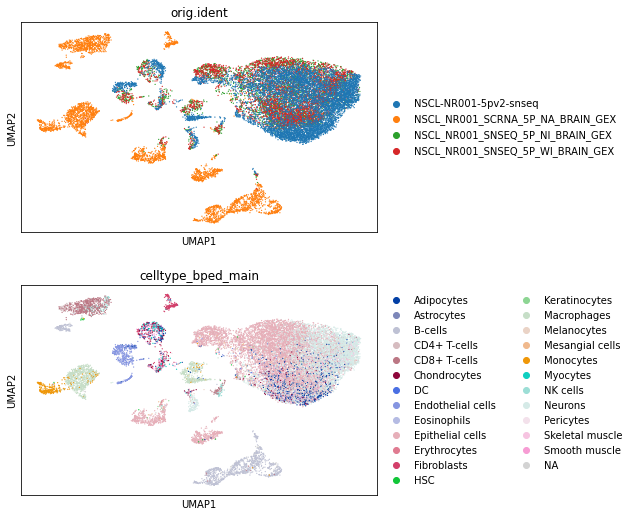

In [55]:
sc.pl.umap(NSCL_merged, color=['orig.ident','celltype_bped_main'],ncols=1)

In [56]:
#save data pre-batch correction
pd.DataFrame(NSCL_merged.obsm["X_umap"]).to_csv("ribas/NSCL/NSCL_5p_raw_umap.csv")
df=NSCL_merged.to_df()
df.columns=NSCL_merged.var_names
df.to_csv("ribas/NSCL/NSCL_5p_no_batch_dense.csv")

#save PCA components
X = NSCL_merged.to_df().to_numpy()
pca = PCA(n_components=20)
pcs = pca.fit_transform(X)
pd.DataFrame(pcs).to_csv("ribas/NSCL/NSCL_5p_merged_NO_BATCH_pcs.csv")

### SCVI

In [19]:
#prepare to run scVI analysis
scvi.data.setup_anndata(NSCL_merged, layer="counts", batch_key="orig.ident")

INFO     Using batches from adata.obs["orig.ident"]                                          
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 19136 cells, 8000 vars, 4 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [20]:
vae = scvi.model.SCVI(NSCL_merged, n_layers=2, n_latent=30)
vae.train()

INFO     Training for 400 epochs                                                             
INFO     KL warmup for 400 epochs                                                            
Training...: 100%|██████████| 400/400 [3:44:50<00:00, 33.73s/it]  
INFO     Training time:  13490 s. / 400 epochs                                               


In [21]:
NSCL_merged.obsm["X_scVI"] = vae.get_latent_representation()

In [23]:
vae.save("ribas/NSCL/NSCL_5p_scvi_model.weights")

In [5]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(NSCL_merged, use_rep="X_scVI")

In [6]:
sc.tl.umap(NSCL_merged)

/home/lf2684/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

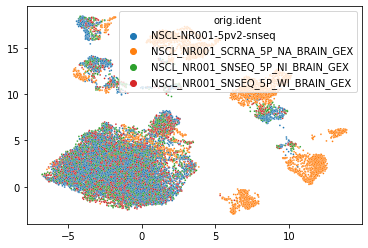

In [19]:
#visualize (with randomization)
randomize=np.arange(NSCL_merged.obs["orig.ident"].shape[0])
np.random.shuffle(randomize)

sns.scatterplot(NSCL_merged.obsm["X_umap"][:,0][randomize],NSCL_merged.obsm["X_umap"][:,1][randomize],hue=NSCL_merged.obs["orig.ident"][randomize],s=3)

In [4]:
#save data for latent space

pd.DataFrame(NSCL_merged.obsm["X_scVI"]).to_csv("ribas/NSCL/NSCL_5p_scvi_latent_components.csv")
pd.DataFrame(NSCL_merged.obsm["X_umap"]).to_csv("ribas/NSCL/NSCL_5p_scvi_latent_umap.csv")

#save PCA components
X = NSCL_merged.obsm['X_scVI']
pca = PCA(n_components=20)
pcs = pca.fit_transform(X)

pd.DataFrame(pcs).to_csv("ribas/NSCL/NSCL_5p_scvi_latent_pcs.csv")

In [33]:
#reconstruct gene space for UMAP (by averaging across all batch transforms)
batch_norm=[]
for i in np.unique(NSCL_merged.obs["orig.ident"]):
    print(i)
    batch_norm.append(vae.get_normalized_expression(transform_batch=i))

NSCL-NR001-5pv2-snseq
NSCL_NR001_SCRNA_5P_NA_BRAIN_GEX
NSCL_NR001_SNSEQ_5P_NI_BRAIN_GEX
NSCL_NR001_SNSEQ_5P_WI_BRAIN_GEX


In [34]:
#add reconstructed data to AnnData object
NSCL_merged.layers["scvi_normalized"]=np.mean(np.asarray(batch_norm),axis=0)

In [35]:
NSCL_merged.write_h5ad("./ribas/NSCL/NSCL_5p_SCVI_MERGED.h5")

In [11]:
NSCL_merged=sc.read_h5ad("./ribas/NSCL/NSCL_5p_SCVI_MERGED.h5")

In [36]:
#create new object using reconstructed data 
normed = sc.AnnData(NSCL_merged.layers["scvi_normalized"])
normed=sc.AnnData(NSCL_merged.layers["scvi_normalized"])
normed.obs["sample"]=list(NSCL_merged.obs["orig.ident"])
normed.obs["celltype"]=list(NSCL_merged.obs["celltype_bped_main"])

In [39]:
sc.pp.neighbors(normed)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [40]:
sc.tl.umap(normed)

... storing 'sample' as categorical
... storing 'celltype' as categorical


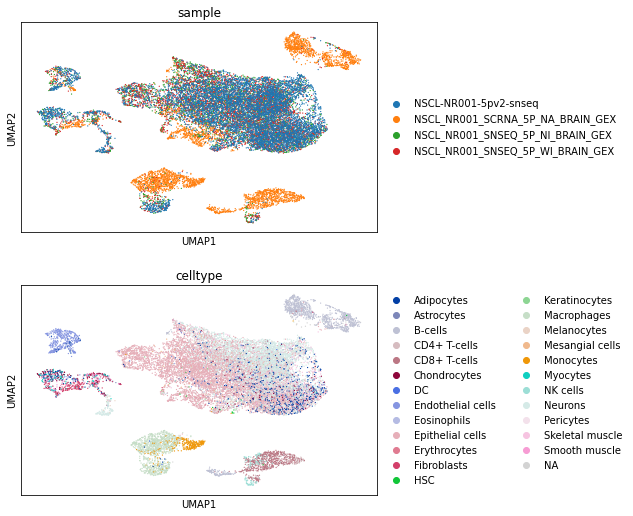

In [41]:
sc.pl.umap(normed,color=["sample", "celltype"],ncols=1)

In [64]:
#save data
pd.DataFrame(normed.obsm["X_umap"]).to_csv("ribas/NSCL/NSCL_5p_scvi_dense_umap.csv")
normed_df=normed.to_df()
normed_df.columns=NSCL_merged.var_names
normed_df.to_csv("ribas/NSCL/NSCL_5p_scvi_dense.csv")

#save PCA components
X = normed.to_df().to_numpy()
pca = PCA(n_components=20)
pcs = pca.fit_transform(X)
pd.DataFrame(pcs).to_csv("ribas/NSCL/NSCL_5p_scvi_dense_pcs.csv")